In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import random
from collections import Counter

import numpy as np

from sklearn.grid_search import GridSearchCV

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

# Load Pickled Labels

In [2]:
directory = 'generated_data'
if not os.path.exists(directory):
    os.makedirs(directory)

train_labels = np.load('{0}/train_labels.dat'.format(directory))
test_labels = np.load('{0}/test_labels.dat'.format(directory))
print('Training labels shape: {0}'.format(train_labels.shape))
print('Testing labels shape:  {0}'.format(test_labels.shape))

Training labels shape: (7326,)
Testing labels shape:  (2603,)


# Load Custom Conversion Data

In [3]:
train_CustGray_2d = np.load('{0}/train_CustGray_2d.dat'.format(directory))
test_CustGray_2d = np.load('{0}/test_CustGray_2d.dat'.format(directory))
print('Custom Conversion training shape: {0}'.format(train_CustGray_2d.shape))
print('Custom Conversion testing shape:  {0}'.format(test_CustGray_2d.shape))

Custom Conversion training shape: (7326, 640)
Custom Conversion testing shape:  (2603, 640)


# Load Otsu's Binarization Threshold Data

In [4]:
train_OBT_2d = np.load('{0}/train_OBT_2d.dat'.format(directory))
test_OBT_2d = np.load('{0}/test_OBT_2d.dat'.format(directory))
print('Otsu training shape: {0}'.format(train_OBT_2d.shape))
print('Otsu testing shape:  {0}'.format(test_OBT_2d.shape))

Otsu training shape: (7326, 640)
Otsu testing shape:  (2603, 640)


# Load Adaptive Mean Threshold Data

In [5]:
train_AMT_2d = np.load('{0}/train_AMT_2d.dat'.format(directory))
test_AMT_2d = np.load('{0}/test_AMT_2d.dat'.format(directory))
print('Adaptive mean training shape: {0}'.format(train_AMT_2d.shape))
print('Adaptive mean testing shape:  {0}'.format(test_AMT_2d.shape))

Adaptive mean training shape: (7326, 640)
Adaptive mean testing shape:  (2603, 640)


# Load Adaptive Gaussian Threshold Data

In [6]:
train_AGT_2d = np.load('{0}/train_AGT_2d.dat'.format(directory))
test_AGT_2d = np.load('{0}/test_AGT_2d.dat'.format(directory))
print('Adaptive Gaussian training shape: {0}'.format(train_AGT_2d.shape))
print('Adaptive Gaussian testing shape:  {0}'.format(test_AGT_2d.shape))

Adaptive Gaussian training shape: (7326, 640)
Adaptive Gaussian testing shape:  (2603, 640)


# Load Principle Component Analysis Data

In [7]:
train_PCA_2d = np.load('{0}/train_PCA_2d.dat'.format(directory))
test_PCA_2d = np.load('{0}/test_PCA_2d.dat'.format(directory))
print('PCA training shape: {0}'.format(train_PCA_2d.shape))
print('PCA testing shape:  {0}'.format(test_PCA_2d.shape))

PCA training shape: (7326, 40)
PCA testing shape:  (2603, 40)


# Lists of Datasets

In [8]:
names = ['Cust', 'OBT', 'AMT', 'AGT', 'PCA']
l_train = [train_CustGray_2d, train_OBT_2d, train_AMT_2d, train_AGT_2d, train_PCA_2d]
l_test = [test_CustGray_2d, test_OBT_2d, test_AMT_2d, test_AGT_2d, test_PCA_2d]
overall_dict = {}

# Visualize Important Pixels

In [9]:
img_dir = 'imgs'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
    
def important_pixels(mdl, save_img, ht=32, wd=20):
    '''
    source: http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances_faces.html#example-ensemble-plot-forest-importances-faces-py
    '''
    importances = mdl.feature_importances_
    try:
        importances = importances.reshape(ht,wd)

        # Plot pixel importances
        plt.matshow(importances, cmap=plt.cm.hot)
        plt.axis('off')
        plt.savefig('{0}/{1}'.format(img_dir, save_img), bbox_inches='tight')
    except:
        pass

# Ada Boost Classifier

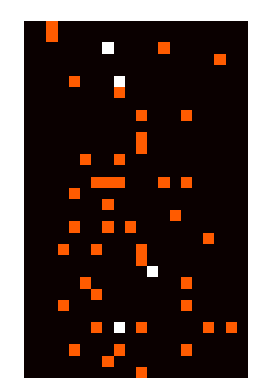

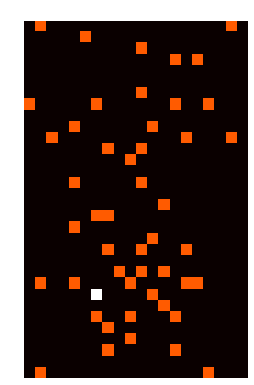

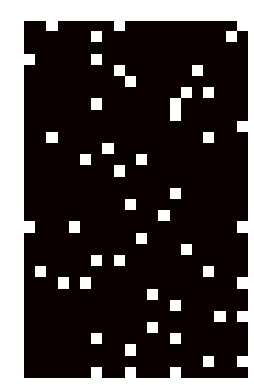

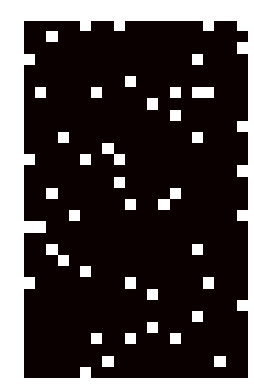

In [10]:
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

# Attributes
# estimators_ : list of classifiers
# classes_ : array of shape = [n_classes]
# n_classes_ : int
# estimator_weights_ : array of floats
# estimator_errors_ : array of floats
# feature_importances_ : array of shape = [n_features]

ab_dict = {}

for i,dataset in enumerate(l_train):
    n_estimators=50
    
    ab_clf = AdaBoostClassifier(base_estimator=None, n_estimators=n_estimators, learning_rate=1.0, 
                                 algorithm='SAMME.R', random_state=None)
    
    ab_mdl = ab_clf.fit(dataset, train_labels) 
   
    scores = cross_val_score(ab_clf, dataset, train_labels)
    
    ab_dict[('ada_boost_{0}'.format(names[i]),n_estimators)] = scores.mean()*100
    
    _ = important_pixels(ab_mdl, 'ada_boost_{0}'.format(names[i]))

In [11]:
overall_dict['ada_boost'] = ab_dict
ab_dict

{('ada_boost_AGT', 50): 19.601571674291097,
 ('ada_boost_AMT', 50): 19.901917264897509,
 ('ada_boost_Cust', 50): 20.760998576551458,
 ('ada_boost_OBT', 50): 20.48886398197746,
 ('ada_boost_PCA', 50): 28.036545130198686}

# Bagging Classifier

In [12]:
from sklearn.ensemble import BaggingClassifier

# Attributes
# base_estimator_ : list of estimators
# estimators_ : list of estimators
# estimators_samples_ : list of arrays
# estimators_features_ : list of arrays
# classes_ : array of shape = [n_classes]
# n_classes_ : int or list
# oob_score_ : float
# oob_decision_function_ : array of shape = [n_samples, n_classes]

bag_dict = {}

for i,dataset in enumerate(l_train):
    bag_clf = BaggingClassifier(base_estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, 
                                bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, 
                                n_jobs=-1, random_state=None, verbose=0)
    scores = cross_val_score(bag_clf, dataset, train_labels)
    bag_dict['bagging_{0}'.format(names[i])] = scores.mean()*100

In [13]:
overall_dict['bagging'] = bag_dict
bag_dict

{'bagging_AGT': 51.323207811328167,
 'bagging_AMT': 58.078788809515736,
 'bagging_Cust': 45.263746911071252,
 'bagging_OBT': 59.895449489481521,
 'bagging_PCA': 46.314940670450547}

# Gradient Boosting Classifier - TAKES A LONG TIME TO RUN

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

# Attributes
# feature_importances_ : array, shape = [n_features]
# oob_improvement_ : array, shape = [n_estimators]
# train_score_ : array, shape = [n_estimators]
# loss_ : LossFunction
# init : BaseEstimator
# estimators_ : ndarray of DecisionTreeRegressor, shape = [n_estimators, loss_.K]
    
gb_dict = {}

for i,dataset in enumerate(l_train):
    n_estimators=100
    gb_clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=n_estimators, subsample=1.0, 
                                     min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                     max_depth=3, init=None, random_state=None, max_features=None, verbose=0, 
                                     max_leaf_nodes=None, warm_start=False, presort='auto')
    
    gb_mdl = gb_clf.fit(dataset, train_labels)
    scores = cross_val_score(gb_clf, dataset, train_labels)
    
    gb_dict[('gradient_boost_{0}'.format(names[i]),n_estimators)] = scores.mean()*100
    
    important_pixels(ab_mdl, 'gradient_boost_{0}'.format(names[i]))

In [15]:
overall_dict['gradient_boost'] = gb_dict
gb_dict

{('gradient_boost_AGT', 100): 66.214155600971665,
 ('gradient_boost_AMT', 100): 69.832856602220886,
 ('gradient_boost_Cust', 100): 48.895452832272127,
 ('gradient_boost_OBT', 100): 65.874941537370447,
 ('gradient_boost_PCA', 100): 51.773845380204733}

# Decision Tree Classifier

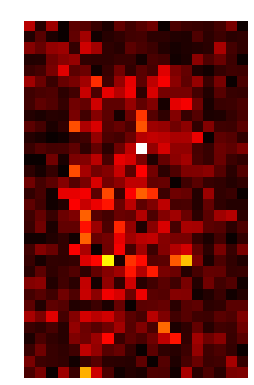

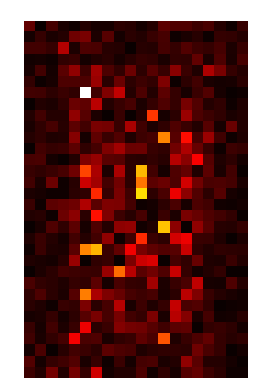

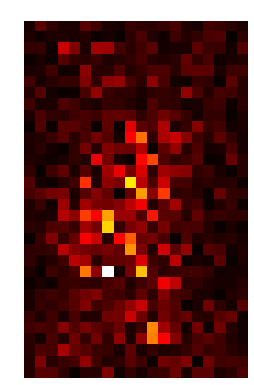

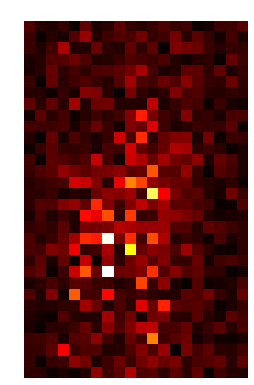

In [16]:
from sklearn.tree import DecisionTreeClassifier

# classes_ : array of shape = [n_classes] or a list of such arrays
# feature_importances_ : array of shape = [n_features]
# max_features_ : int,
# n_classes_ : int or list
# n_features_ : int
# n_outputs_ : int
# tree_ : Tree object

dtr_dict = {}

for i,dataset in enumerate(l_train):
    dtr_clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, 
                            min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, 
                            max_leaf_nodes=None, class_weight=None, presort=False)

    dtr_mdl = dtr_clf.fit(dataset, train_labels)
    
    scores = cross_val_score(dtr_clf, dataset, train_labels)
    
    dtr_dict['decision_tree_{0}'.format(names[i])] = scores.mean()*100
    
    important_pixels(dtr_mdl, 'decision_tree{0}'.format(names[i]))

In [17]:
overall_dict['decision_tree'] = dtr_dict
dtr_dict

{'decision_tree_AGT': 36.130857420444769,
 'decision_tree_AMT': 40.362788173834971,
 'decision_tree_Cust': 32.214331923276276,
 'decision_tree_OBT': 45.522068371907089,
 'decision_tree_PCA': 33.388778964927127}

# Extra Trees Classifier

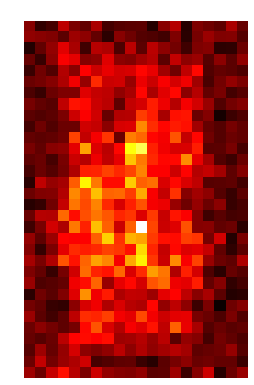

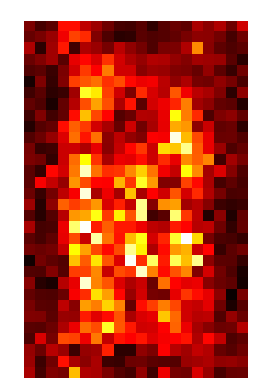

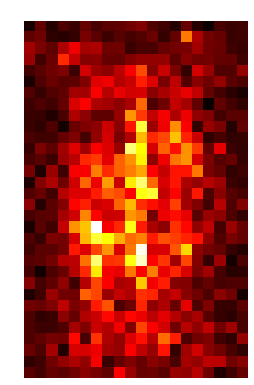

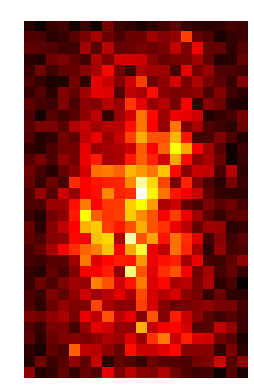

In [18]:
from sklearn.ensemble import ExtraTreesClassifier

etr_dict = {}

for i,dataset in enumerate(l_train):
    
    etr_clf = ExtraTreesClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, 
                    min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, 
                    bootstrap=False, oob_score=False, n_jobs=-1, random_state=None, verbose=0, warm_start=False, 
                    class_weight=None)

    etr_mdl = etr_clf.fit(dataset, train_labels)
    
    scores = cross_val_score(etr_clf, dataset, train_labels)
    
    etr_dict['extra_trees_{0}'.format(names[i])] = scores.mean()*100
    
    important_pixels(etr_mdl, 'extra_tree{0}'.format(names[i]))

In [19]:
overall_dict['extra_trees'] = etr_dict
etr_dict

{'extra_trees_AGT': 51.583040717644423,
 'extra_trees_AMT': 58.107135290679402,
 'extra_trees_Cust': 44.308735504452159,
 'extra_trees_OBT': 59.322666965762906,
 'extra_trees_PCA': 39.338396227783853}

# Random Forrest Classifier

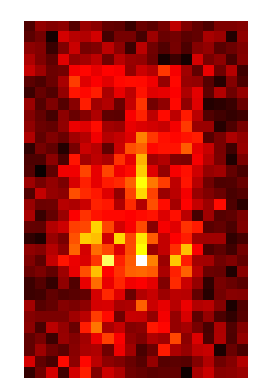

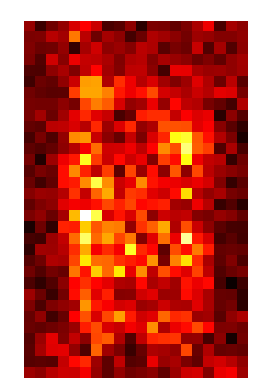

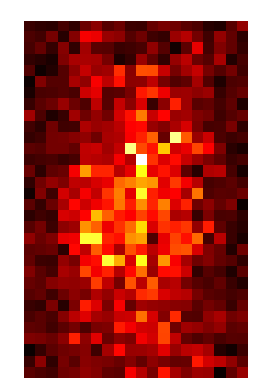

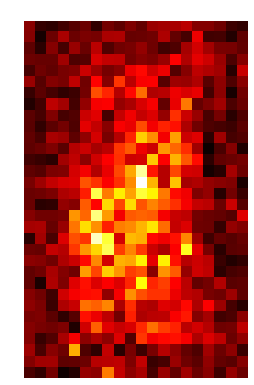

In [20]:
from sklearn.ensemble import RandomForestClassifier

# Attributes
# estimators_ : list of DecisionTreeClassifier
# classes_ : array of shape = [n_classes] or a list of such arrays
# n_classes_ : int or list
# n_features_ : int
# n_outputs_ : int
# feature_importances_ : array of shape = [n_features]
# oob_score_ : float
# oob_decision_function_ : array of shape = [n_samples, n_classes]
    
rf_dict = {}

for i,dataset in enumerate(l_train):
    rf_clf = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, 
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                                max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=-1, random_state=None, 
                                verbose=0, warm_start=False, class_weight=None)
    
    rf_mdl = rf_clf.fit(dataset, train_labels)
    
    scores = cross_val_score(rf_clf, dataset, train_labels)
    
    rf_dict['random_forrest_{0}'.format(names[i])] = scores.mean()*100
    
    important_pixels(rf_mdl, 'random_forrest{0}'.format(names[i]))

In [21]:
overall_dict['random_forrest'] = rf_dict
rf_dict

{'random_forrest_AGT': 47.924649879384475,
 'random_forrest_AMT': 53.726729803985798,
 'random_forrest_Cust': 42.684224820751901,
 'random_forrest_OBT': 57.125658373257103,
 'random_forrest_PCA': 42.657086086872283}

# KNN

In [22]:
from sklearn.neighbors import KNeighborsClassifier
    
knn_dict = {}

for i,dataset in enumerate(l_train):
    knn_clf = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                                   metric='minkowski', metric_params=None, n_jobs=-1)
    
    knn_mdl = knn_clf.fit(dataset, train_labels)
    
    scores = cross_val_score(knn_clf, dataset, train_labels)
    
    knn_dict['kneighbors_{0}'.format(names[i])] = scores.mean()*100

In [23]:
overall_dict['kneighbors'] = knn_dict
knn_dict

{'kneighbors_AGT': 60.278115454419712,
 'kneighbors_AMT': 63.771514237182359,
 'kneighbors_Cust': 44.868008839839568,
 'kneighbors_OBT': 56.469231326074706,
 'kneighbors_PCA': 61.575175530410156}

# SVM Classifier

In [24]:
from sklearn.svm import SVC

svc_dict = {}

for i,dataset in enumerate(l_train):
    svc_clf = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=False, 
                  tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, 
                  decision_function_shape=None)
    
    scores = cross_val_score(svc_clf, dataset, train_labels)
    svc_dict['svc_{0}'.format(names[i])] = scores.mean()*100

In [25]:
overall_dict['svc'] = svc_dict
svc_dict

{'svc_AGT': 19.178291874734157,
 'svc_AMT': 19.178291874734157,
 'svc_Cust': 19.178291874734157,
 'svc_OBT': 19.178291874734157,
 'svc_PCA': 65.969377416059118}

# Logistic Regression Classifier

In [26]:
from sklearn.linear_model import SGDClassifier

logr_dict = {}

for i,dataset in enumerate(l_train):
    logr_clf = SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, n_iter=5, 
                             shuffle=True, verbose=0, epsilon=0.1, n_jobs=-1, random_state=None, learning_rate='optimal', 
                             eta0=0.0, power_t=0.5, class_weight=None, warm_start=False, average=False)
    
    scores = cross_val_score(logr_clf, dataset, train_labels)
    logr_dict['log_regression_{0}'.format(names[i])] = scores.mean()*100

In [27]:
overall_dict['log_regression'] = logr_dict
logr_dict

{'log_regression_AGT': 16.026441077516719,
 'log_regression_AMT': 15.850924187266582,
 'log_regression_Cust': 17.373385579404925,
 'log_regression_OBT': 14.921522839842694,
 'log_regression_PCA': 15.725106157039825}

In [28]:
list(overall_dict.values())

[{'decision_tree_AGT': 36.130857420444769,
  'decision_tree_AMT': 40.362788173834971,
  'decision_tree_Cust': 32.214331923276276,
  'decision_tree_OBT': 45.522068371907089,
  'decision_tree_PCA': 33.388778964927127},
 {'svc_AGT': 19.178291874734157,
  'svc_AMT': 19.178291874734157,
  'svc_Cust': 19.178291874734157,
  'svc_OBT': 19.178291874734157,
  'svc_PCA': 65.969377416059118},
 {'log_regression_AGT': 16.026441077516719,
  'log_regression_AMT': 15.850924187266582,
  'log_regression_Cust': 17.373385579404925,
  'log_regression_OBT': 14.921522839842694,
  'log_regression_PCA': 15.725106157039825},
 {'random_forrest_AGT': 47.924649879384475,
  'random_forrest_AMT': 53.726729803985798,
  'random_forrest_Cust': 42.684224820751901,
  'random_forrest_OBT': 57.125658373257103,
  'random_forrest_PCA': 42.657086086872283},
 {'bagging_AGT': 51.323207811328167,
  'bagging_AMT': 58.078788809515736,
  'bagging_Cust': 45.263746911071252,
  'bagging_OBT': 59.895449489481521,
  'bagging_PCA': 46.314

In [29]:
mdls = [k for k,v in overall_dict.items()]
lst_cnts = []
for k,v in overall_dict.items():
    temp = []
    for x,y in overall_dict[v].values():
        temp.append(y)
    lst_cnts.append(temp)

TypeError: unhashable type: 'dict'

In [ ]:
ind = range(1,6)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, menMeans, width, color='r', yerr=menStd)


rects2 = ax.bar(ind + width, womenMeans, width, color='y', yerr=womenStd)

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(ind + width)
ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))

ax.legend((rects1[0], rects2[0]), ('Men', 'Women'))


def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()


In [ ]:
# make figure
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

# plots
plt.bar(range(len(train_cnt_dict)), train_cnt_dict.values(), , color=colors[5], 
                alpha=0.5, edgecolor='w', label='Training Labels')

# labels/titles
plt.legend(loc="best")
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Class Labels')

plt.xlim(-0.5,9.5)
ticks = [0,1,2,3,4,5,6,7,8,9]
plt.xticks(ticks, ticks)

# remove border
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.spines["left"].set_visible(False)

# show grid
ax.yaxis.grid(True) 

# plot that biddy
plt.tight_layout()
_ = plt.show()